### Index

[1. Presentation of the challenge](#1) <br>
- [1.1 - The RavenPack Data Science Challenge](#1.1) <br>
- [1.2 - Overview of the approach](#1.2)<br><br>

[2. Collect & transform data](#2) <br>
- [2.1 - Connection à SQL Server](#2.1) <br>
- [2.2 - Mise au format des données](#2.2)<br>
- [](#2.3)<br>
- [](#2.4)<br>
- [](#2.5)<br>

[3. Descriptive analysis / Statistical inferences](#3) <br>
- [](#3.1)<br>
- [](#3.2)<br>
- [](#3.3)<br>
- [](#3.4)<br>

[4. Preprocess the data](#4) <br>
- [4.1 - Clustering](#4.1)<br>
- [4.2 - Création de la target (y)](#4.2)<br>
- [4.3 - Valeurs aberrantes](#4.3)<br>
- [4.4 - One-hot-encoding](#4.4)<br><br>

[5. Create features](#5) <br>
- [5.1 - Dataset du modèle 1](#5.1)<br>
- [](#5.2)<br>
- [](#5.3)<br>
- [](#5.4)<br>

[6. Select a ML algo](#6) <br>
- [6.1 - Dataset du modèle 1](#6.1)<br>
- [](#6.2)<br>
- [](#6.3)<br>
- [](#6.4)<br>

[7. Backtest on unseen data](#7) <br>
- [7.1 - Dataset du modèle 1](#7.1)<br>
- [](#7.2)<br>
- [](#7.3)<br>
- [](#7.4)<br>

In [1]:
# Imports & Settings

In [2]:
# Loading data

In [3]:
# Remove stocks with insufficient observations

In [4]:
# Add some Basic Factors : Compute the Relative Strength Index, Compute Moving Average Convergence/Divergence

In [5]:
# Remove outliers

In [6]:
# Create time and sector dummy variables

In [7]:
# !pip install tscv

In [8]:
import talib
from talib import RSI, BBANDS, MACD, ATR

In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.core.display import display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tslearn.utils import to_time_series_dataset

In [10]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [11]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statistics
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import statistics
# from yellowbrick.model_selection import ValidationCurve, LearningCurve


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from statistics import *
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [12]:
# %store -r cluster_dict
# %store -r add_features
# %store -r dataset

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

In [14]:
display(HTML("<style> *{margin:0; padding:0;} html, body, \
             .container{margin:2;!important padding:0;!important} \
             .container { width:100% !important;}</style>"))

In [15]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]


nb_date_ceil = 15000
nb_date_floor = 110 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]

df['T0_RETURN_log'] = np.log(1+df.loc[:,'T0_RETURN'].copy()) ##use log return
df['T1_RETURN_log'] = np.log(1+df.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df_ = df.loc[:, ~df.columns.isin(cols_to_drop)].copy()

In [16]:
daily_returns = df_.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
# daily_returns = daily_returns.resample('D').sum().dropna(how='all')
daily_returns = daily_returns.loc[daily_returns.index.year >= 2004,:]
daily_returns = daily_returns.dropna(how='all')
daily_returns

RP_ENTITY_ID  00067A  003B70  006885  009397  013528  0157B1  018C11  0246B2  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan   0.018     nan     nan   
2005-01-04       nan     nan     nan     nan     nan  -0.038     nan     nan   
2005-01-05     0.029     nan     nan     nan     nan   0.001     nan     nan   
2005-01-06    -0.006     nan     nan     nan     nan     nan  -0.004     nan   
2005-01-07       nan     nan     nan     nan     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.003   0.002     nan     nan   0.001   0.008     nan  -0.024   
2017-02-14    -0.007  -0.017     nan  -0.006   0.000  -0.004     nan   0.008   
2017-02-15    -0.008  -0.013     nan  -0.004  -0.007   0.002     nan     nan   
2017-02-16     0.019   0.006     nan     nan   0.015   0.004     nan  -0.003   
2017-02-17    -0.022     nan     nan   0.002     nan  -0.001     nan     nan   

RP_ENTITY_ID  02631C  031B03  034B61  03596A  03B8CF  03CF95  03FAA6  047E26  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-04       nan     nan     nan     nan     nan     nan     nan  -0.016   
2005-01-05       nan     nan     nan     nan     nan     nan     nan   0.014   
2005-01-06       nan     nan     nan     nan     nan     nan     nan   0.011   
2005-01-07       nan     nan     nan     nan     nan     nan     nan  -0.006   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan     nan     nan     nan   0.008   0.011   0.013  -0.017   
2017-02-14       nan     nan  -0.009   0.008  -0.000   0.008   0.027   0.022   
2017-02-15       nan     nan   0.002   0.008   0.002   0.001  -0.007   0.000   
2017-02-16       nan     nan     nan  -0.010     nan   0.009   0.001  -0.011   
2017-02-17       nan     nan     nan     nan     nan     nan  -0.004     nan   

RP_ENTITY_ID  048590  055018  055551  0555FF  061366  061856  0624BE  063384  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-04       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-05       nan  -0.001     nan     nan     nan     nan     nan     nan   
2005-01-06       nan     nan     nan     nan     nan     nan   0.051     nan   
2005-01-07       nan     nan  -0.001     nan     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13    -0.036   0.004     nan     nan   0.011   0.008     nan     nan   
2017-02-14    -0.019   0.010     nan     nan   0.014  -0.005     nan   0.000   
2017-02-15     0.006   0.003     nan     nan     nan  -0.003     nan   0.091   
2017-02-16     0.000  -0.003   0.139     nan  -0.016   0.004     nan   0.005   
2017-02-17    -0.003   0.013   0.026   0.009     nan  -0.003     nan     nan   

RP_ENTITY_ID  0665EF  067779  067883  06E74C  06EF42  06F889  070B45  072FC5  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-04       nan     nan     nan     nan     nan     nan     nan  -0.002   
2005-01-05       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-06    -0.010     nan     nan     nan     nan     nan     nan     nan   
2005-01-07       nan     nan     nan     nan     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan     nan     nan     nan     nan     nan   0.000     nan   
2017-02-14       nan  -0.005     nan     nan  -0.014     nan  -0.003     nan   
2017-02-15       nan     nan     nan     nan     nan     nan     nan     nan 

In [17]:
freq = '6BMS' #'BY'
daily_returns_count6M = daily_returns.resample(freq).count()

In [18]:
daily_returns_count6M_selec = daily_returns_count6M>=110

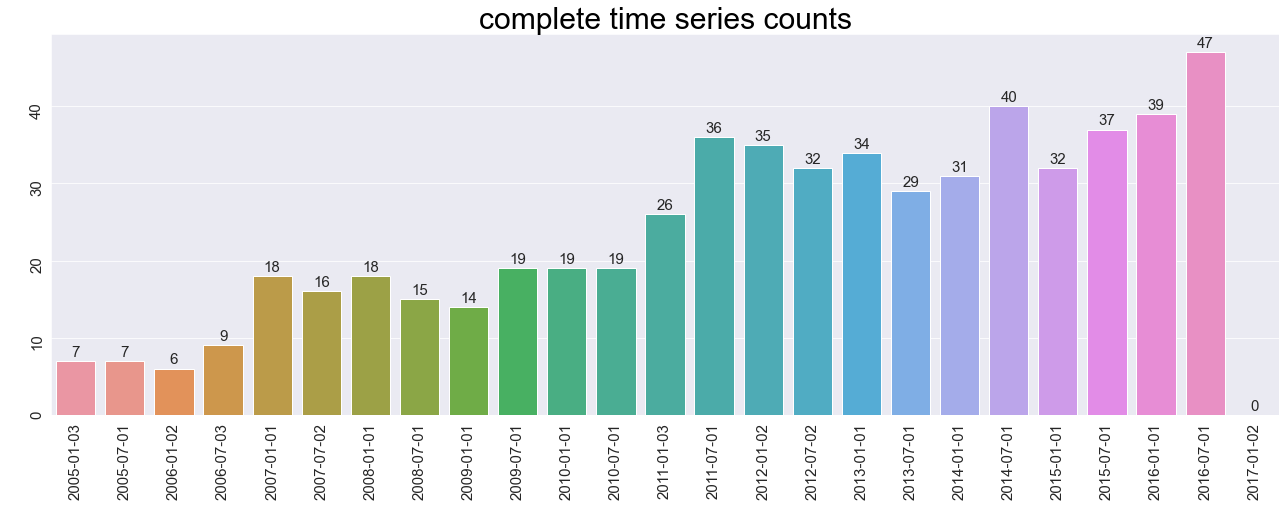

In [19]:
df_hist = (daily_returns_count6M>=110).sum(axis=1)#.reset_index()
df_hist.index=df_hist.index.strftime('%Y-%m-%d')

fig = plt.figure(1, figsize=(22, 7))
sns.set_style('darkgrid', {'legend.frameon':True})
b = sns.barplot(x = df_hist.reset_index().iloc[:,0], y = df_hist.reset_index().iloc[:,1])

for p in b.patches:
    b.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
b.axes.set_title("complete time series counts",fontsize=30, color='black')
b.set_xlabel("time",fontsize=20, color='w')
b.set_ylabel("count",fontsize=20, color='w')
b.tick_params(labelsize=15, rotation=90)

In [20]:
datasset_per_Semester = list(daily_returns_count6M_selec.replace(False, np.NaN)
                             .dropna(how='all', axis=1))

In [21]:
dataset_inter = {}
for idx in list(daily_returns_count6M_selec.index):
    dataset_inter[idx] = list(daily_returns_count6M_selec.loc[idx].index[daily_returns_count6M_selec.loc[idx].values])

In [22]:
dataset ={k: v for k, v in dataset_inter.items() if k.year >= 2011}

In [23]:
%store dataset

Stored 'dataset' (dict)


In [24]:
%store -r dataset

In [25]:
dataset

{Timestamp('2011-01-03 00:00:00', freq='6BMS'): ['061856',
  '17EDA5',
  '1921DD',
  '228D42',
  '25102A',
  '251988',
  '3461CF',
  '42ABA7',
  '4A6F00',
  '4AC91D',
  '50070E',
  '619882',
  '713810',
  '73C521',
  '8D4486',
  '9196A2',
  '990AD0',
  'A0D8E6',
  'A6828A',
  'B3CB74',
  'C83B88',
  'CFF97C',
  'D6489C',
  'D8442A',
  'D91D4E',
  'E8846E'],
 Timestamp('2011-07-01 00:00:00', freq='6BMS'): ['0157B1',
  '061856',
  '168A5D',
  '17EDA5',
  '1921DD',
  '1BC12C',
  '228D42',
  '25102A',
  '251988',
  '267718',
  '3461CF',
  '42ABA7',
  '4A6F00',
  '4AC91D',
  '50070E',
  '619882',
  '6203E4',
  '713810',
  '73C521',
  '8A8E41',
  '8D4486',
  '9196A2',
  '972356',
  '990AD0',
  'A0D8E6',
  'A18D3C',
  'B3CB74',
  'C83B88',
  'CFF97C',
  'D6489C',
  'D8442A',
  'D91D4E',
  'E49AA3',
  'E70531',
  'E8846E',
  'ECD263'],
 Timestamp('2012-01-02 00:00:00', freq='6BMS'): ['0157B1',
  '061856',
  '12DE76',
  '168A5D',
  '17EDA5',
  '1921DD',
  '1BC12C',
  '228D42',
  '25102A',
  '25

In [26]:
timestamp_dataset = list(dataset.keys())
asset_dataset = list(dataset.values())

In [27]:
data = {}
for i in range(len(timestamp_dataset)-1):
    data[i] = df_.loc[
        (df_['DATE']>=timestamp_dataset[i]) 
        & (df_['DATE']<timestamp_dataset[i+1])
        & (df_['RP_ENTITY_ID'].isin(asset_dataset[i]))
        , :]

In [28]:
mylist=[]
for i in range(12):
    print(len(data[i]))
    mylist.append(len(data[i]))
sum(mylist)

3126
4337
4177
3886
4073
3564
3786
4900
3840
4510
4673
5751


50623

In [30]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

lags = [1, 3, 5, 10, 21]
q = 0.0001

___
# Add Features
___

In [31]:
%store -r cluster_dict
df_all = pd.DataFrame()
nb=0


for i in range(len(data)):
    df0 = data[i]
    #add cluster
    df0['cluster'] = df0['RP_ENTITY_ID'].map(cluster_dict)
    df0 = df0.dropna(subset=['cluster'])
    df0['cluster'] = df0['cluster'].astype('int64')
    
    daily_returns = df0.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
    # daily_returns = daily_returns.resample('D').sum().dropna(how='all')
    daily_returns = daily_returns.loc[daily_returns.index.year >= 2010,:]
    daily_returns = daily_returns.dropna(how='all')
    
    #Compute the Relative Strength Index
    prices = daily_returns.copy()
    prices =  np.exp(prices).cumprod()*100
    # price.pivot_table(index='DATE', columns='RP_ENTITY_ID')
    # price.iloc[0,:]=100
    prices = pd.DataFrame(prices.unstack(0))
    prices.rename(columns={0: 'close'}, inplace=True)
    add_features = pd.DataFrame()
    add_features['rsi'] = prices.dropna().groupby(level='RP_ENTITY_ID').close.apply(RSI)/100-0.5
    
    #Compute Bollinger Band
    prices = (prices.join(prices.dropna()
                      .groupby(level='RP_ENTITY_ID')
                      .close
                      .apply(compute_bb)))
    add_features['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
    add_features['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
    prices.drop(['bb_high', 'bb_low'], axis=1, inplace=True)
    
    #Compute Moving Average Convergence/Divergence
    add_features['macd'] = (prices.dropna()
                  .groupby('RP_ENTITY_ID', group_keys=False)
                  .close
                  .apply(compute_macd))
    
    #Compute Lagged Returns
    returns = prices.groupby(level='RP_ENTITY_ID').close.pct_change()
    percentiles=[.0001, .001, .01]
    percentiles+= [1-p for p in percentiles]
    returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')
    
    #Winsorize outliers
    for lag in lags:
        add_features[f'return_{lag}d'] = (prices.groupby(level='RP_ENTITY_ID').close
                                    .pct_change(lag)
                                    .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                           upper=x.quantile(1 - q)))
                                    .add(1)
                                    .pow(1 / lag)
                                    .sub(1)
                                    )
    
    #Shift lagged returns
    for t in [1, 2, 3, 4, 5]:
        for lag in [1, 5, 10, 21]:
            add_features[f'return_{lag}d_lag{t}'] = (add_features.groupby(level='RP_ENTITY_ID')
                                               [f'return_{lag}d'].shift(t * lag))
        
    #merge cluster
    df0 =  pd.merge(df0, add_features.reset_index(), on=['RP_ENTITY_ID','DATE'], how='outer') 
    
    #replace RP_ENTITY_ID with number
    val_unique = df0.RP_ENTITY_ID.unique()
    nbval_unique = len(df0.RP_ENTITY_ID.unique())
    for n, val in enumerate(val_unique):
        df0['RP_ENTITY_ID'].replace(val, n+nb, inplace=True)
    nb+=nbval_unique
    df_all = pd.concat([df_all, df0])

In [32]:
df0 = df_all

In [33]:
df0

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log,cluster,rsi,bb_high,bb_low,macd,return_1d,return_3d,return_5d,return_10d,return_21d,return_1d_lag1,return_5d_lag1,return_10d_lag1,return_21d_lag1,return_1d_lag2,return_5d_lag2,return_10d_lag2,return_21d_lag2,return_1d_lag3,return_5d_lag3,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5
0,0,2011-01-03,0.180,nan,0.180,nan,nan,nan,nan,nan,nan,nan,nan,0.180,nan,nan,nan,nan,nan,nan,nan,nan,0.180,nan,nan,nan,nan,nan,nan,0.180,-0.009,0.008,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,2011-01-04,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.008,-0.009,1,nan,nan,nan,nan,0.008,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,2011-01-05,0.347,0.095,0.514,0.173,0.095,0.640,0.173,0.095,0.640,nan,nan,0.514,nan,nan,nan,nan,nan,nan,0.091,0.000,0.514,0.107,0.000,0.640,0.107,0.000,0.640,0.514,-0.009,0.002,1,nan,nan,nan,nan,-0.009,nan,nan,nan,nan,0.008,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,2011-01-06,0.061,0.000,0.275,0.000,0.000,nan,0.000,0.000,nan,nan,nan,0.275,nan,nan,nan,nan,nan,nan,0.000,0.000,0.275,0.000,0.000,nan,0.000,0.000,nan,0.275,0.002,0.004,1,nan,nan,nan,nan,0.002,0.000,nan,nan,nan,-0.009,nan,nan,nan,0.008,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,2011-01-07,0.140,0.063,0.239,0.114,0.063,0.570,0.114,0.063,0.570,nan,nan,0.239,nan,nan,nan,nan,nan,nan,0.000,0.000,0.239,0.000,0.000,nan,0.000,0.000,nan,0.239,0.004,-0.010,1,nan,nan,nan,nan,0.004,-0.001,nan,nan,nan,0.002,nan,nan,nan,-0.009,nan,nan,nan,0.008,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,383,2016-12-22,-0.495,-0.990,0.000,-0.495,-0.990,0.000,-0.495,-0.990,0.000,-0.990,-0.990,0.000,-0.990,-0.990,nan,-0.990,-0.990,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.002,-0.003,0,0.067,0.011,0.057,-0.345,-0.002,0.002,0.001,0.003,0.002,0.014,0.005,0.002,-0.005,-0.007,0.003,-0.011,0.011,0.007,0.001,-0.001,0.002,-0.005,0.005,0.021,-0.002,0.010,-0.026,0.011,nan
5258,383,2016-12-23,0.390,0.475,0.305,0.475,0.475,nan,0.475,0.475,nan,0.475,0.475,0.305,0.475,0.475,nan,0.475,0.475,nan,0.305,nan,0.305,nan,nan,nan,nan,nan,nan,0.305,-0.003,0.018,0,0.057,0.016,0.052,-0.331,-0.003,0.003,0.002,0.003,0.002,-0.002,0.005,0.001,-0.006,0.014,-0.004,-0.011,0.014,-0.007,0.007,-0.002,0.002,0.007,0.005,0.022,-0.002,-0.005,-0.026,0.009,nan
5259,383,2016-12-27,0.087,-0.340,0.300,0.130,-0.340,0.600,0.600,nan,0.600,-0.340,-0.340,0.300,-0.340,-0.340,nan,nan,nan,nan,0.300,nan,0.300,0.600,nan,0.600,0.600,nan,0.600,0.300,0.018,-0.010,0,0.112,0.002,0.067,-0.257,0.019,0.005,0.004,0.005,0.003,-0.003,0.005,0.002,-0.006,-0.002,0.002,-0.008,0.015,0.014,0.001,-0.005,0.002,-0.007,0.000,0.024,0.003,0.007,-0.016,0.005,nan
5260,383,2016-12-28,-0.580,nan,-0.580,-0.580,nan,-0.580,-0.580,nan,-0.580,-0.580,nan,-0.580,-0.580,nan,-0.580,-0.580,nan,-0.580,nan,nan,-0.580,nan,nan,nan,nan,nan,nan,-0.580,-0.010,-0.006,0,0.072,0.013,0.055,-0.238,-0.009,0.002,0.004,0.003,0.003,0.019,0.003,0.002,-0.006,-0.

___
#  <a id =6> </a> **6. Select a ML algo**
___

# XGBOOST

In [34]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [35]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time, MultipleTimeSeriesCV

In [36]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [37]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

In [38]:
df = df0.set_index(['RP_ENTITY_ID', 'DATE']).copy()
df_i = df.copy()
df_i = df_i.dropna(subset=['T1_RETURN_log'])


In [39]:
df_i

GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
RP_ENTITY_ID DATE                                               
0            2011-01-03       0.180          nan        0.180   
             2011-01-04       0.000          nan        0.000   
             2011-01-05       0.347        0.095        0.514   
             2011-01-06       0.061        0.000        0.275   
             2011-01-07       0.140        0.063        0.239   
...                             ...          ...          ...   
383          2016-12-22      -0.495       -0.990        0.000   
             2016-12-23       0.390        0.475        0.305   
             2016-12-27       0.087       -0.340        0.300   
             2016-12-28      -0.580          nan       -0.580   
             2016-12-30       0.610          nan        0.610   

                         GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  \
RP_ENTITY_ID DATE                                                              
0            2011-01-03              nan               nan               nan   
             2011-01-04            0.000               nan             0.000   
             2011-01-05            0.173             0.095             0.640   
             2011-01-06            0.000             0.000               nan   
             2011-01-07            0.114             0.063             0.570   
...                                  ...               ...               ...   
383          2016-12-22           -0.495            -0.990             0.000   
             2016-12-23            0.475             0.475               nan   
             2016-12-27            0.130            -0.340             0.600   
             2016-12-28           -0.580               nan            -0.580   
             2016-12-30              nan               nan               nan   

                         GLOBAL_ALL_SG365  GLOBAL_HEAD_SG365  \
RP_ENTITY_ID DATE                                              
0            2011-01-03               nan                nan   
             2011-01-04             0.000                nan   
             2011-01-05             0.173              0.095   
             2011-01-06             0.000              0.000   
             2011-01-07             0.114              0.063   
...                                   ...                ...   
383          2016-12-22            -0.495             -0.990   
             2016-12-23             0.475              0.475   
             2016-12-27             0.600                nan   
             2016-12-28            -0.580                nan   
             2016-12-30               nan                nan   

                         GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
RP_ENTITY_ID DATE                                                       
0            2011-01-03                nan          nan           nan   
             2011-01-04              0.000        0.000           nan   
             2011-01-05              0.640          nan           nan   
             2011-01-06                nan          nan           nan   
             2011-01-07              0.570          nan           nan   
...                                    ...          ...           ...   
383          2016-12-22              0.000       -0.990        -0.990   
             2016-12-23                nan        0.475         0.475   
             2016-12-27              0.600       -0.340        -0.340   
             2016-12-28             -0.580       -0.580           nan   
             2016-12-30                nan          nan           nan   

                         GROUP_A_BODY  GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  \
RP_ENTITY_ID DATE                                                            
0            2011-01-03         0.180               nan                nan   
             2011-01-04         0.000             0.000                nan   
             2011-01-05         0.514      

In [40]:
# df_i = df_i.loc[df_i['cluster']==4,:]
# df_i.iloc[:,:31]

In [41]:
# y, X = get_data()
# X_dummies = get_one_hot_data(features)
# X_factors = factorize_cats(features)

In [42]:
def get_data(start='2010', end='2015', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = 'T1_RETURN_log'
    ddf = df_i.copy()

    if start is not None and end is not None:
        ddf = ddf.loc[idx[:, start: end], :]
    if dropna:
        ddf = ddf.dropna()
        
    y = (ddf[target]>0).astype(int)
    X = ddf.loc[:,~ddf.columns.str.contains('T1_RETURN')]
    return y, X

In [43]:
y, X = get_data()
# # X_dummy = pd.get_dummies(X['cluster'], prefix='cluster')
# # X = X.join(X_dummy)
# # X_dummy = pd.get_dummies(X['cluster'], prefix='cluster')
X =  pd.get_dummies(X,
                        columns=['cluster'],
                        prefix=['cluster'],
                        prefix_sep=['_'])

X = X.loc[:, ~X.columns.isin(['GROUP_E_BODY', 'GROUP_A_BODY', 'GROUP_AM_BODY'])]
# X =  X.loc[:, ~X.columns.str.contains('lag|GLOBAL')]
# X =  X.loc[:, X.columns.str.contains('rsi|macd|return')]
# X = X.loc[:, X.columns.isin(['rsi', 'macd', 'return_5d', 'return_10d', 'return_21d', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])]

X = X.loc[:, X.columns.isin([
# 'return_21d_lag5',
#  'GROUP_E_HEAD_SG365',
#  'cluster_1',
#  'GLOBAL_HEAD_SG365',
#  'GLOBAL_BODY_SG365',
#  'GLOBAL_BODY',
#  'GROUP_E_ALL_SG365',
#  'GROUP_A_HEAD_SG365',
#  'return_1d_lag2',
#  'GLOBAL_ALL_SG365',
#  'GLOBAL_HEAD',
#  'return_21d_lag4',
#  'return_5d_lag2',
#  'GROUP_E_HEAD_SG90',
#  'GLOBAL_HEAD_SG90',
#  'GROUP_E_ALL',
#  'GROUP_A_BODY_SG90',
#  'return_21d_lag3',
#  'return_5d_lag5',
#  'return_21d_lag2',
#  'GROUP_A_BODY_SG365',
#  'GROUP_E_BODY_SG365',
#  'GLOBAL_ALL',
#  'GROUP_A_ALL',
#  'GROUP_A_HEAD_SG90',
#  'GROUP_A_HEAD',
#  'return_5d_lag4',
#  'cluster_2',
#  'GROUP_E_ALL_SG90',
#  'GLOBAL_BODY_SG90',
#  'GROUP_A_ALL_SG90',
#  'return_10d_lag1',
#  'return_10d_lag4',
#  'bb_high',
 'return_3d',
 'GROUP_E_HEAD',
 'GLOBAL_ALL_SG90',
 'return_10d_lag2',
 'return_1d_lag5',
 'return_1d_lag1',
 'return_1d_lag4',
 'return_1d_lag3',
 'T0_RETURN_log',
 'return_21d_lag1',
 'GROUP_E_BODY_SG90',
 'return_10d',
 'return_10d_lag5',
 'return_1d',
 'return_10d_lag3',
 'GROUP_A_ALL_SG365',
 'return_5d_lag1',
 'bb_low',
 'return_5d_lag3',
 'cluster_0',
 'rsi',
 'return_21d',
 'return_5d',
 'macd'])]
X

GLOBAL_ALL_SG90  GROUP_A_ALL_SG365  GROUP_E_HEAD  \
RP_ENTITY_ID DATE                                                           
0            2011-01-03              nan                nan           nan   
             2011-01-04            0.000              0.000           nan   
             2011-01-05            0.173                nan         0.000   
             2011-01-06            0.000                nan         0.000   
             2011-01-07            0.114                nan         0.000   
...                                  ...                ...           ...   
304          2015-12-23            0.000              0.000           nan   
             2015-12-24              nan                nan           nan   
             2015-12-28           -0.287                nan           nan   
             2015-12-29              nan                nan           nan   
             2015-12-30            0.000              0.000           nan   

                         GROUP_E_BODY_SG90  T0_RETURN_log   rsi  bb_low  macd  \
RP_ENTITY_ID DATE                                                               
0            2011-01-03                nan         -0.009   nan     nan   nan   
             2011-01-04                nan          0.008   nan     nan   nan   
             2011-01-05              0.640         -0.009   nan     nan   nan   
             2011-01-06                nan          0.002   nan     nan   nan   
             2011-01-07                nan          0.004   nan     nan   nan   
...                                    ...            ...   ...     ...   ...   
304          2015-12-23              0.000         -0.005 0.021   0.029 1.118   
             2015-12-24                nan         -0.003 0.001   0.026 0.911   
             2015-12-28             -0.740          0.003 0.017   0.026 0.770   
             2015-12-29                nan          0.002 0.030   0.026 0.677   
             2015-12-30                nan          0.001 0.037   0.024 0.607   

                         return_1d  return_3d  return_5d  return_10d  \
RP_ENTITY_ID DATE                                                      
0            2011-01-03        nan        nan        nan         nan   
             2011-01-04      0.008        nan        nan         nan   
             2011-01-05     -0.009        nan        nan         nan   
             2011-01-06      0.002      0.000        nan         nan   
             2011-01-07      0.004     -0.001        nan         nan   
...                            ...        ...        ...         ...   
304          2015-12-23     -0.005     -0.004     -0.004       0.001   
             2015-12-24     -0.003     -0.004     -0.007       0.000   
             2015-12-28      0.003     -0.002     -0.003       0.000   
             2015-12-29      0.002      0.000     -0.002       0.000   
             2015-12-30      0.001      0.002     -0.001      -0.002   

                         return_21d  return_1d_lag1  return_5d_lag1  \
RP_ENTITY_ID DATE                                                     
0            2011-01-03         nan             nan             nan   
             2011-01-04         nan             nan             nan   
             2011-01-05         nan           0.008             nan   
             2011-01-06         nan          -0.009             nan   
             2011-01-07         nan           0.002             nan   
...                             ...             ...             ...   
304          2015-12-23       0.001          -0.004           0.006   
             2015-12-24       0.001          -0.005           0.007   
             2015-12-28       0.001          -0.003           0.003   
             2015-12-29       0.001           0.003           0.002   
             2015-12-30       0.001           0.002          -0.002   

                         return_21d_lag1  return_10d_lag2  return_1d_lag3  \
RP_ENTITY_ID DATE              

In [44]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('DATE').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [45]:
# target = y
# features = X.loc[:,~X.columns.str.contains('T1')]
# get_holdout_set(target, features, period=6)
# # X_train

In [46]:
train_period_length = 37
test_period_length = 10
YEAR = 110
n_splits = 8 #int(1 * YEAR / test_period_length) # 6 years
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)
# import tscv
# from tscv import GapKFold
# cv = GapKFold(n_splits=8, gap_before=1, gap_after=1)

In [47]:
# from tscv import GapKFold
# cv = GapKFold(n_splits=5, gap_before=1, gap_after=1)
# for train, test in cv.split(range(10)):
#     print("train:", train, "test:", test)

In [48]:
run_time = {}

In [49]:
metrics = {'balanced_accuracy': 'Accuracy' ,
#            'roc_auc': 'AUC',
#            'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [50]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

In [51]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [52]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

In [53]:
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)


### Cross-validate

In [54]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import datetime
# from datetime import datetime

# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [55]:
# A parameter grid for XGBoost
# params = {
#         'n_estimators': [10,100,300,500,700],
#         'learning_rate': [0.002, 0.02, 0.2, 0.4, 0.6],
#         'min_child_weight': [1, 5, 10 ],#10
#         'gamma': [0.5, 1, 1.5,2,5],#2, 5
#         'subsample': [0.6, 0.8, 1.0],#1.0
#         'colsample_bytree': [0.6, 0.8, 1.0],#1.0
#         'max_depth': [3, 4, 5]#5
#         }

In [56]:
# param_comb = 7

# random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=16, cv=cv, verbose=3, random_state=42 )

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X, y)
# timer(start_time) # timing ends here for "start_time" variable

In [57]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# # print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)

In [58]:
algo = 'xgboost'

In [59]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
#     xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


1151 Int64Index([32996, 32997, 32998, 32999, 33000, 33001, 33002, 33003, 33004,
            33005,
            ...
            36936, 36937, 36938, 36939, 36940, 36941, 36942, 36943, 36944,
            36945],
           dtype='int64', length=1151) 291 Int64Index([33032, 33033, 33034, 33035, 33036, 33037, 33038, 33039, 33040,
            33041,
            ...
            36833, 36946, 36947, 36948, 36949, 36950, 36951, 36952, 36953,
            36954],
           dtype='int64', length=291)
1159 Int64Index([32987, 32988, 32989, 32990, 32991, 32992, 32993, 32994, 32995,
            32996,
            ...
            36926, 36927, 36928, 36929, 36930, 36931, 36932, 36933, 36934,
            36935],
           dtype='int64', length=1159) 312 Int64Index([33022, 33023, 33024, 33025, 33026, 33027, 33028, 33029, 33030,
            33031,
            ...
            36936, 36937, 36938, 36939, 36940, 36941, 36942, 36943, 36944,
            36945],
           dtype='int64', length=312)
1172 Int

[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    6.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.9s finished


In [60]:
xgb_cv_result

{'fit_time': array([5.78751707, 5.54217339, 5.43346238, 5.69875431, 5.72169328,
        5.6488862 , 5.75360656, 5.68279767]),
 'score_time': array([0.00797868, 0.00698137, 0.00698137, 0.00698161, 0.00897622,
        0.01196837, 0.00897574, 0.0079782 ]),
 'test_balanced_accuracy': array([0.50529049, 0.59325397, 0.56995641, 0.52080721, 0.5582104 ,
        0.53299471, 0.53170263, 0.56322115]),
 'train_balanced_accuracy': array([0.81764368, 0.79204828, 0.79383514, 0.77856926, 0.77250049,
        0.79364603, 0.78444834, 0.77095125]),
 'test_f1_weighted': array([0.50212232, 0.59354772, 0.53581733, 0.52582865, 0.54190338,
        0.50889751, 0.53004195, 0.56329114]),
 'train_f1_weighted': array([0.81756235, 0.79254297, 0.79720274, 0.77977045, 0.77570345,
        0.7936993 , 0.78452056, 0.77141794]),
 'test_precision_weighted': array([0.5230593 , 0.59561885, 0.59306419, 0.5253397 , 0.56756704,
        0.55541629, 0.53245178, 0.56329114]),
 'train_precision_weighted': array([0.81769817, 0.79387

### Plot Results

In [61]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

# Accuracy	0.538	0.842
# F1	0.530	0.843
# Precision	0.547	0.846
# Recall	0.535	0.844

Dataset,Test,Train
Metric,,
Accuracy,0.547,0.788
F1,0.538,0.789
Precision,0.557,0.792
Recall,0.540,0.790


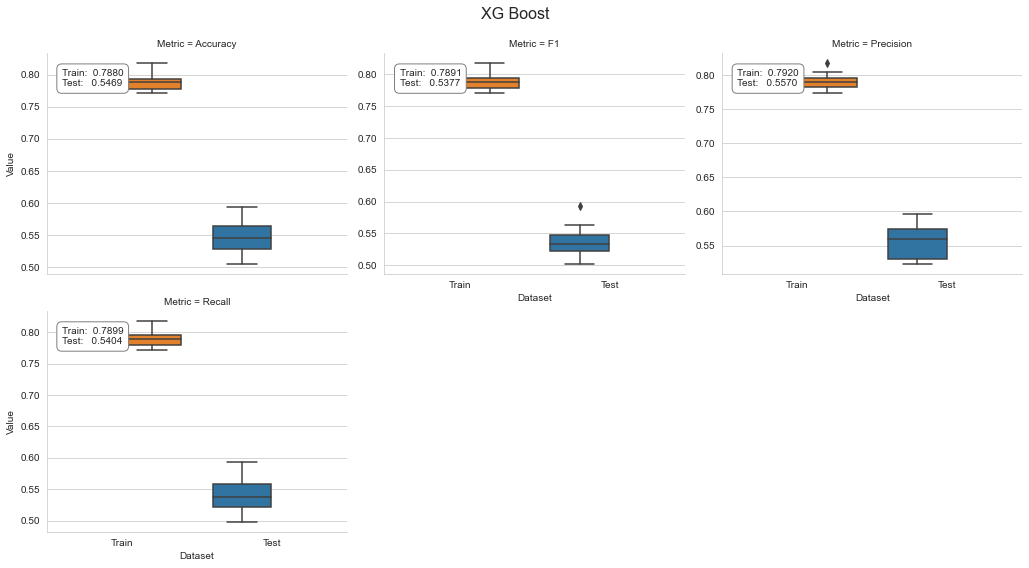

In [62]:
plot_result(xbg_result, model='XG Boost')#, fname=f'figures/{algo}_cv_result')

### Feature Importance

In [63]:
xgb_clf.fit(X=X, y=y)

[12:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [64]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X.columns)

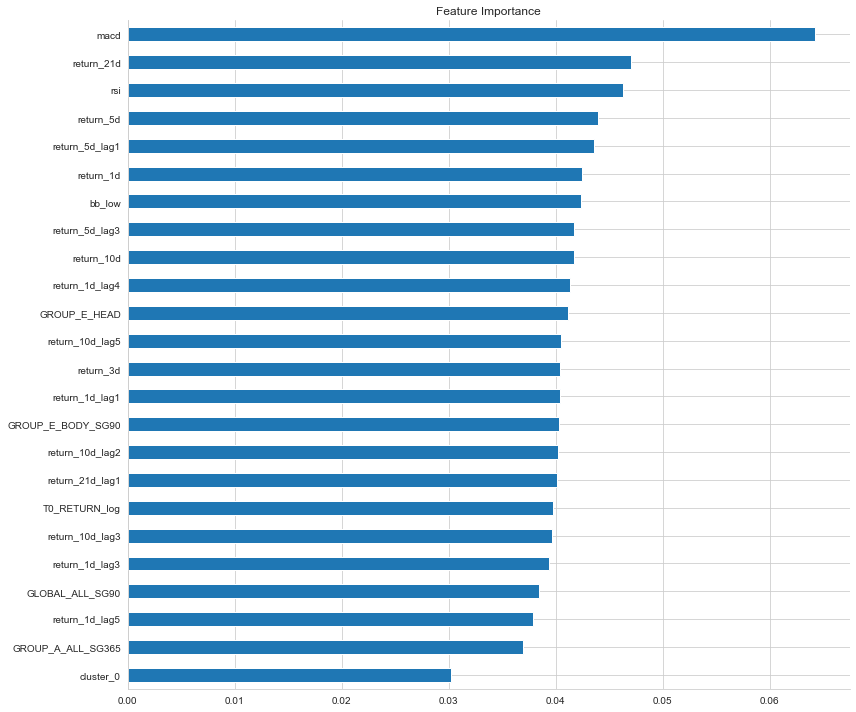

In [65]:
fi.nlargest(70).sort_values().plot.barh(figsize=(12, 10), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

In [66]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X.columns)
list(fi.nlargest(70).sort_values().index)


['cluster_0',
 'GROUP_A_ALL_SG365',
 'return_1d_lag5',
 'GLOBAL_ALL_SG90',
 'return_1d_lag3',
 'return_10d_lag3',
 'T0_RETURN_log',
 'return_21d_lag1',
 'return_10d_lag2',
 'GROUP_E_BODY_SG90',
 'return_1d_lag1',
 'return_3d',
 'return_10d_lag5',
 'GROUP_E_HEAD',
 'return_1d_lag4',
 'return_10d',
 'return_5d_lag3',
 'bb_low',
 'return_1d',
 'return_5d_lag1',
 'return_5d',
 'rsi',
 'return_21d',
 'macd']

In [67]:
y, X = get_data(start='2016', end='2017')
# # X_dummy = pd.get_dummies(X['cluster'], prefix='cluster')
# # X = X.join(X_dummy)
# # X_dummy = pd.get_dummies(X['cluster'], prefix='cluster')
X =  pd.get_dummies(X,
                        columns=['cluster'],
                        prefix=['cluster'],
                        prefix_sep=['_'])

X = X.loc[:, ~X.columns.isin([ 'GROUP_E_BODY', 'GROUP_A_BODY', 'GROUP_AM_BODY'])]
X = X.loc[:, X.columns.isin([
# 'return_21d_lag5',
#  'GROUP_E_HEAD_SG365',
#  'cluster_1',
#  'GLOBAL_HEAD_SG365',
#  'GLOBAL_BODY_SG365',
#  'GLOBAL_BODY',
#  'GROUP_E_ALL_SG365',
#  'GROUP_A_HEAD_SG365',
#  'return_1d_lag2',
#  'GLOBAL_ALL_SG365',
#  'GLOBAL_HEAD',
#  'return_21d_lag4',
#  'return_5d_lag2',
#  'GROUP_E_HEAD_SG90',
#  'GLOBAL_HEAD_SG90',
#  'GROUP_E_ALL',
#  'GROUP_A_BODY_SG90',
#  'return_21d_lag3',
#  'return_5d_lag5',
#  'return_21d_lag2',
#  'GROUP_A_BODY_SG365',
#  'GROUP_E_BODY_SG365',
#  'GLOBAL_ALL',
#  'GROUP_A_ALL',
#  'GROUP_A_HEAD_SG90',
#  'GROUP_A_HEAD',
#  'return_5d_lag4',
#  'cluster_2',
#  'GROUP_E_ALL_SG90',
#  'GLOBAL_BODY_SG90',
#  'GROUP_A_ALL_SG90',
#  'return_10d_lag1',
#  'return_10d_lag4',
#  'bb_high',
 'return_3d',
 'GROUP_E_HEAD',
 'GLOBAL_ALL_SG90',
 'return_10d_lag2',
 'return_1d_lag5',
 'return_1d_lag1',
 'return_1d_lag4',
 'return_1d_lag3',
 'T0_RETURN_log',
 'return_21d_lag1',
 'GROUP_E_BODY_SG90',
 'return_10d',
 'return_10d_lag5',
 'return_1d',
 'return_10d_lag3',
 'GROUP_A_ALL_SG365',
 'return_5d_lag1',
 'bb_low',
 'return_5d_lag3',
 'cluster_0',
 'rsi',
 'return_21d',
 'return_5d',
 'macd'])]
# X =  X.loc[:, ~X.columns.str.contains('lag')]
# X =  X.loc[:, X.columns.str.contains('rsi|macd|return')]
# X = X.loc[:, X.columns.isin(['rsi', 'macd', 'return_5d', 'return_10d', 'return_21d'])]
# X = X.loc[:, X.columns.str.contains('rsi|macd|return_5d|return_10d|return_21d|cluster')]
# X = X.loc[:, X.columns.isin(['rsi', 'macd', 'return_5d', 'return_10d', 'return_21d', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])]
X

GLOBAL_ALL_SG90  GROUP_A_ALL_SG365  GROUP_E_HEAD  \
RP_ENTITY_ID DATE                                                           
305          2016-01-04           -0.580             -0.580           nan   
             2016-01-05           -0.313                nan         0.000   
             2016-01-06            0.220                nan           nan   
             2016-01-07            0.310                nan           nan   
             2016-01-08            0.620                nan           nan   
...                                  ...                ...           ...   
383          2016-12-22           -0.495             -0.990           nan   
             2016-12-23            0.475              0.475           nan   
             2016-12-27            0.130                nan           nan   
             2016-12-28           -0.580             -0.580           nan   
             2016-12-30              nan                nan           nan   

                         GROUP_E_BODY_SG90  T0_RETURN_log   rsi  bb_low  \
RP_ENTITY_ID DATE                                                         
305          2016-01-04                nan         -0.048   nan     nan   
             2016-01-05             -0.434         -0.005   nan     nan   
             2016-01-06                nan          0.017   nan     nan   
             2016-01-07              0.000         -0.013   nan     nan   
             2016-01-08                nan          0.010   nan     nan   
...                                    ...            ...   ...     ...   
383          2016-12-22              0.000         -0.002 0.067   0.057   
             2016-12-23                nan         -0.003 0.057   0.052   
             2016-12-27              0.600          0.018 0.112   0.067   
             2016-12-28                nan         -0.010 0.072   0.055   
             2016-12-30                nan         -0.009 0.038   0.041   

                          macd  return_1d  return_3d  return_5d  return_10d  \
RP_ENTITY_ID DATE                                                             
305          2016-01-04    nan        nan        nan        nan         nan   
             2016-01-05    nan     -0.005        nan        nan         nan   
             2016-01-06    nan      0.017        nan        nan         nan   
             2016-01-07    nan     -0.013     -0.000        nan         nan   
             2016-01-08    nan      0.010      0.004        nan         nan   
...                        ...        ...        ...        ...         ...   
383          2016-12-22 -0.345     -0.002      0.002      0.001       0.003   
             2016-12-23 -0.331     -0.003      0.003      0.002       0.003   
             2016-12-27 -0.257      0.019      0.005      0.004       0.005   
             2016-12-28 -0.238     -0.009      0.002      0.004       0.003   
             2016-12-30 -0.258     -0.009     -0.006     -0.000       0.000   

                         return_21d  return_1d_lag1  return_5d_lag1  \
RP_ENTITY_ID DATE                                                     
305          2016-01-04         nan             nan             nan   
             2016-01-05         nan             nan             nan   
             2016-01-06         nan          -0.005             nan   
             2016-01-07         nan           0.017             nan   
             2016-01-08         nan          -0.013             nan   
...                             ...             ...             ...   
383          2016-12-22       0.002           0.014           0.005   
             2016-12-23       0.002          -0.002           0.005   
             2016-12-27       0.003          -0.003           0.005   
             2016-12-28       0.003           0.019           0.003   
             2016-12-30       0.002          -0.009           0.004   

                         return_21d_lag1  return_10d_lag2  return_1d_lag3  \
RP_ENTITY_ID DATE 

In [68]:
def confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(15,10))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [69]:
# y_hat = xgb_clf.predict_proba(X)
y_hat = xgb_clf.predict(X)

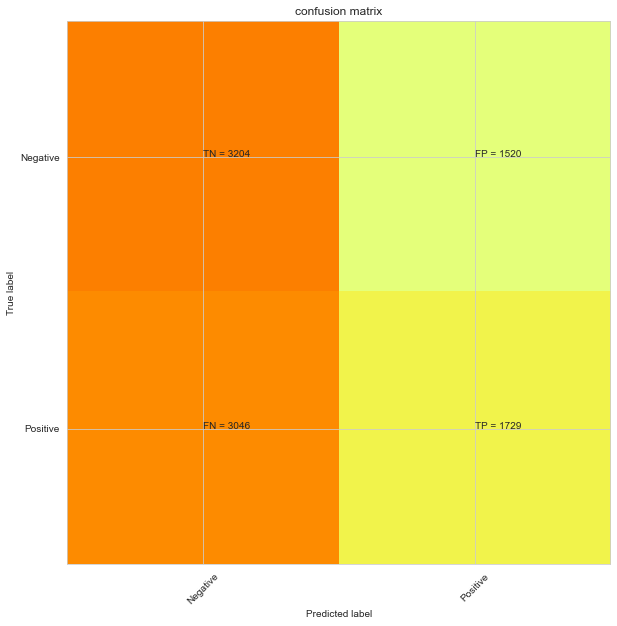

In [70]:
confusio_matrix(y, y_hat)

In [71]:
y

RP_ENTITY_ID  DATE      
305           2016-01-04    0
              2016-01-05    1
              2016-01-06    0
              2016-01-07    1
              2016-01-08    1
                           ..
383           2016-12-22    0
              2016-12-23    1
              2016-12-27    0
              2016-12-28    0
              2016-12-30    1
Name: T1_RETURN_log, Length: 9499, dtype: int32

In [72]:
y_hat

array([0, 0, 0, ..., 0, 1, 1])

In [73]:

y_hat

array([0, 0, 0, ..., 0, 1, 1])

In [74]:
y_hat = xgb_clf.predict(X)
y_hat

array([0, 0, 0, ..., 0, 1, 1])

In [75]:
np.abs(y-y_hat).sum()

4566

In [76]:
1-(np.abs(y-y_hat).sum())/len(y)

0.5193178229287294

In [77]:
1-np.abs(y-y_hat).sum()/len(y)
# 0.516370144225708

0.5193178229287294

In [78]:
X

GLOBAL_ALL_SG90  GROUP_A_ALL_SG365  GROUP_E_HEAD  \
RP_ENTITY_ID DATE                                                           
305          2016-01-04           -0.580             -0.580           nan   
             2016-01-05           -0.313                nan         0.000   
             2016-01-06            0.220                nan           nan   
             2016-01-07            0.310                nan           nan   
             2016-01-08            0.620                nan           nan   
...                                  ...                ...           ...   
383          2016-12-22           -0.495             -0.990           nan   
             2016-12-23            0.475              0.475           nan   
             2016-12-27            0.130                nan           nan   
             2016-12-28           -0.580             -0.580           nan   
             2016-12-30              nan                nan           nan   

                         GROUP_E_BODY_SG90  T0_RETURN_log   rsi  bb_low  \
RP_ENTITY_ID DATE                                                         
305          2016-01-04                nan         -0.048   nan     nan   
             2016-01-05             -0.434         -0.005   nan     nan   
             2016-01-06                nan          0.017   nan     nan   
             2016-01-07              0.000         -0.013   nan     nan   
             2016-01-08                nan          0.010   nan     nan   
...                                    ...            ...   ...     ...   
383          2016-12-22              0.000         -0.002 0.067   0.057   
             2016-12-23                nan         -0.003 0.057   0.052   
             2016-12-27              0.600          0.018 0.112   0.067   
             2016-12-28                nan         -0.010 0.072   0.055   
             2016-12-30                nan         -0.009 0.038   0.041   

                          macd  return_1d  return_3d  return_5d  return_10d  \
RP_ENTITY_ID DATE                                                             
305          2016-01-04    nan        nan        nan        nan         nan   
             2016-01-05    nan     -0.005        nan        nan         nan   
             2016-01-06    nan      0.017        nan        nan         nan   
             2016-01-07    nan     -0.013     -0.000        nan         nan   
             2016-01-08    nan      0.010      0.004        nan         nan   
...                        ...        ...        ...        ...         ...   
383          2016-12-22 -0.345     -0.002      0.002      0.001       0.003   
             2016-12-23 -0.331     -0.003      0.003      0.002       0.003   
             2016-12-27 -0.257      0.019      0.005      0.004       0.005   
             2016-12-28 -0.238     -0.009      0.002      0.004       0.003   
             2016-12-30 -0.258     -0.009     -0.006     -0.000       0.000   

                         return_21d  return_1d_lag1  return_5d_lag1  \
RP_ENTITY_ID DATE                                                     
305          2016-01-04         nan             nan             nan   
             2016-01-05         nan             nan             nan   
             2016-01-06         nan          -0.005             nan   
             2016-01-07         nan           0.017             nan   
             2016-01-08         nan          -0.013             nan   
...                             ...             ...             ...   
383          2016-12-22       0.002           0.014           0.005   
             2016-12-23       0.002          -0.002           0.005   
             2016-12-27       0.003          -0.003           0.005   
             2016-12-28       0.003           0.019           0.003   
             2016-12-30       0.002          -0.009           0.004   

                         return_21d_lag1  return_10d_lag2  return_1d_lag3  \
RP_ENTITY_ID DATE 

In [79]:
# import torch
# torch.cuda.empty_cache()

In [80]:
y_hat

array([0, 0, 0, ..., 0, 1, 1])

___
# <a id =7> </a> **7. Backtest on unseen data**
___

In [81]:
data[10]

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log,cluster
5853,0157B1,2016-01-04,-0.482,-0.580,-0.399,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.399,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,0.203,nan,-0.399,nan,nan,nan,nan,nan,nan,-0.399,-0.048,-0.005,1.000
5854,0157B1,2016-01-05,-0.165,-0.290,-0.146,-0.313,0.000,-0.352,-0.313,0.000,-0.352,-0.580,-0.580,-0.146,nan,nan,nan,nan,nan,nan,-0.128,0.000,-0.146,-0.380,0.000,-0.434,-0.380,0.000,-0.434,-0.146,-0.005,0.017,1.000
5855,0157B1,2016-01-06,0.110,nan,0.110,0.220,nan,0.220,0.220,nan,0.220,nan,nan,0.110,nan,nan,nan,nan,nan,nan,0.000,nan,0.110,nan,nan,nan,nan,nan,nan,0.110,0.017,-0.013,1.000
5856,0157B1,2016-01-07,0.566,nan,0.566,0.310,nan,0.310,0.310,nan,0.310,nan,nan,0.566,nan,nan,nan,nan,nan,nan,0.320,nan,0.566,0.000,nan,0.000,0.000,nan,0.000,0.566,-0.013,0.010,1.000
5857,0157B1,2016-01-08,0.620,nan,0.620,0.620,nan,0.620,0.620,nan,0.620,nan,nan,0.620,nan,nan,nan,nan,nan,nan,nan,nan,0.620,nan,nan,nan,nan,nan,nan,0.620,0.010,0.024,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653554,E8846E,2016-06-24,-0.040,-0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.040,-0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,-0.004,0.014,2.000
653555,E8846E,2016-06-27,0.064,0.000,0.580,0.145,0.000,0.580,0.145,0.000,0.580,0.000,0.000,0.580,0.000,0.000,nan,0.000,0.000,nan,nan,nan,0.580,nan,nan,nan,nan,nan,nan,0.580,0.014,0.003,2.000
653556,E8846E,2016-06-28,-0.086,0.089,-0.493,-0.172,0.207,-0.740,-0.172,0.207,-0.740,0.077,0.089,-0.493,0.207,0.207,nan,0.207,0.207,nan,-0.740,nan,-0.493,-0.740,nan,-0.740,-0.740,nan,-0.740,-0.493,0.003,-0.001,2.000
653557,E8846E,2016-06-29,0.017,-0.082,0.167,0.083,0.000,0.250,0.000,0.000,0.000,0.000,0.000,0.167,0.000,0.000,0.000,0.000,0.000,0.000,-0.740,-0.740,0.167,nan,nan,nan,nan,nan,nan,0.167,-0.001,-0.007,2.000


In [82]:
data[11].RP_ENTITY_ID.unique()

array(['0157B1', '055018', '061856', '12A3A3', '12DE76', '12E454',
       '17EDA5', '1921DD', '1BC12C', '1D3EEA', '228D42', '2491BC',
       '24CB56', '25102A', '251988', '267718', '4A6F00', '50070E',
       '520632', '523A06', '619882', '61B81B', '6203E4', '713810',
       '88598A', '8A8E41', '8D4486', '912DC9', '9196A2', '93F9E0',
       '990AD0', '9C512F', 'A18D3C', 'A6213D', 'B3CB74', 'BB127B',
       'C83B88', 'CFF15D', 'CFF97C', 'D6489C', 'D64C6D', 'D8442A',
       'D91D4E', 'DD3BB1', 'E70531', 'E8846E', 'ECD263'], dtype=object)

In [83]:
set(data[10].RP_ENTITY_ID.unique())-set(data[11].RP_ENTITY_ID.unique())

{'0F7B72', '168A5D', '2B49F4', '940C3D', 'BA5900'}

In [84]:
set(data[11].RP_ENTITY_ID.unique())-set(data[10].RP_ENTITY_ID.unique())

{'055018',
 '520632',
 '61B81B',
 '6203E4',
 '713810',
 '88598A',
 '912DC9',
 'BB127B',
 'CFF15D',
 'D6489C',
 'D64C6D',
 'E70531',
 'ECD263'}

In [85]:
asset_bt = set.intersection(set(data[10].RP_ENTITY_ID.unique()), set(data[11].RP_ENTITY_ID.unique()))

In [93]:
df_bt = df_.loc[(df_.RP_ENTITY_ID.isin(asset_bt))&(df_.DATE.dt.year>=2016),:].copy()

In [94]:
df_all = pd.DataFrame()
nb=0

df0 = df_bt 
#add cluster
df0['cluster'] = df0['RP_ENTITY_ID'].map(cluster_dict)
df0 = df0.dropna(subset=['cluster'])
df0['cluster'] = df0['cluster'].astype('int64')

daily_returns = df0.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
# daily_returns = daily_returns.resample('D').sum().dropna(how='all')
daily_returns = daily_returns.loc[daily_returns.index.year >= 2010,:]
daily_returns = daily_returns.dropna(how='all')

#Compute the Relative Strength Index
prices = daily_returns.copy()
prices =  np.exp(prices).cumprod()*100
# price.pivot_table(index='DATE', columns='RP_ENTITY_ID')
# price.iloc[0,:]=100
prices = pd.DataFrame(prices.unstack(0))
prices.rename(columns={0: 'close'}, inplace=True)
add_features = pd.DataFrame()
add_features['rsi'] = prices.dropna().groupby(level='RP_ENTITY_ID').close.apply(RSI)/100-0.5

#Compute Bollinger Band
prices = (prices.join(prices.dropna()
                  .groupby(level='RP_ENTITY_ID')
                  .close
                  .apply(compute_bb)))
add_features['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
add_features['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
prices.drop(['bb_high', 'bb_low'], axis=1, inplace=True)

#Compute Moving Average Convergence/Divergence
add_features['macd'] = (prices.dropna()
              .groupby('RP_ENTITY_ID', group_keys=False)
              .close
              .apply(compute_macd))

#Compute Lagged Returns
returns = prices.groupby(level='RP_ENTITY_ID').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

#Winsorize outliers
for lag in lags:
    add_features[f'return_{lag}d'] = (prices.groupby(level='RP_ENTITY_ID').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

#Shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        add_features[f'return_{lag}d_lag{t}'] = (add_features.groupby(level='RP_ENTITY_ID')
                                           [f'return_{lag}d'].shift(t * lag))

#merge cluster
df0 =  pd.merge(df0, add_features.reset_index(), on=['RP_ENTITY_ID','DATE'], how='outer') 


In [105]:
df0

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log,cluster,rsi,bb_high,bb_low,macd,return_1d,return_3d,return_5d,return_10d,return_21d,return_1d_lag1,return_5d_lag1,return_10d_lag1,return_21d_lag1,return_1d_lag2,return_5d_lag2,return_10d_lag2,return_21d_lag2,return_1d_lag3,return_5d_lag3,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5
0,0157B1,2016-01-04,-0.482,-0.580,-0.399,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.399,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,0.203,nan,-0.399,nan,nan,nan,nan,nan,nan,-0.399,-0.048,-0.005,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0157B1,2016-01-05,-0.165,-0.290,-0.146,-0.313,0.000,-0.352,-0.313,0.000,-0.352,-0.580,-0.580,-0.146,nan,nan,nan,nan,nan,nan,-0.128,0.000,-0.146,-0.380,0.000,-0.434,-0.380,0.000,-0.434,-0.146,-0.005,0.017,1,nan,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0157B1,2016-01-06,0.110,nan,0.110,0.220,nan,0.220,0.220,nan,0.220,nan,nan,0.110,nan,nan,nan,nan,nan,nan,0.000,nan,0.110,nan,nan,nan,nan,nan,nan,0.110,0.017,-0.013,1,nan,nan,nan,nan,0.017,nan,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0157B1,2016-01-07,0.566,nan,0.566,0.310,nan,0.310,0.310,nan,0.310,nan,nan,0.566,nan,nan,nan,nan,nan,nan,0.320,nan,0.566,0.000,nan,0.000,0.000,nan,0.000,0.566,-0.013,0.010,1,nan,nan,nan,nan,-0.013,-0.000,nan,nan,nan,0.017,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0157B1,2016-01-08,0.620,nan,0.620,0.620,nan,0.620,0.620,nan,0.620,nan,nan,0.620,nan,nan,nan,nan,nan,nan,nan,nan,0.620,nan,nan,nan,nan,nan,nan,0.620,0.010,0.024,1,nan,nan,nan,nan,0.010,0.004,nan,nan,nan,-0.013,nan,nan,nan,0.017,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8632,E8846E,2017-02-13,0.024,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.017,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.240,nan,0.039,nan,nan,nan,nan,nan,nan,0.039,0.001,0.012,2,0.024,0.023,0.036,0.566,0.001,0.003,-0.001,-0.000,0.001,-0.003,0.001,0.001,-0.001,0.012,0.006,-0.001,0.002,-0.015,-0.003,0.001,0.003,-0.002,0.001,0.004,-0.003,-0.009,-0.003,-0.003,0.001
8633,E8846E,2017-02-14,-0.031,0.000,-0.041,-0.145,0.000,-0.580,-0.145,0.000,-0.580,-0.031,0.000,-0.041,-0.145,0.000,-0.580,-0.145,0.000,-0.580,nan,nan,-0.041,nan,nan,nan,nan,nan,nan,-0.041,0.012,0.005,2,0.076,0.011,0.043,0.622,0.012,0.003,0.001,0.001,0.001,0.001,0.001,0.004,-0.001,-0.003,0.007,-0.005,0.001,0.012,0.001,0.000,0.006,-0.015,-0.003,0.002,-0.002,-0.002,-0.006,0.001,0.000
8634,E8846E,2017-02-15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.005,-0.005,2,0.094,0.007,0.043,0.690,0.005,0.006,0.005,0.001,0.003,0.012,-0.003,0.004,-0.002,0.001,0.001,-0.004,-0.000,-0.003,0.006,0.001,0.006,0.012,-0.002,-0.001,-0.002,-0.015,-0.007,0.003,-0.000
8635,E8846E,2017-02-16,-0.090,-0.126,-0.068,-0.129,-0.097,-0.193,-0.136,-0.105,-0.193,-0.150,-0.126,-0.068,-0.136,-0.097,-0.232,-0.145,-0.105,-0.232,0.374,nan,-0.068,0.000,nan,0.000,0.000,n

In [109]:
X = df0.copy()

X =  pd.get_dummies(X,
                        columns=['cluster'],
                        prefix=['cluster'],
                        prefix_sep=['_'])

X = X.loc[:, X.columns.isin([
# 'return_21d_lag5',
#  'GROUP_E_HEAD_SG365',
#  'cluster_1',
#  'GLOBAL_HEAD_SG365',
#  'GLOBAL_BODY_SG365',
#  'GLOBAL_BODY',
#  'GROUP_E_ALL_SG365',
#  'GROUP_A_HEAD_SG365',
#  'return_1d_lag2',
#  'GLOBAL_ALL_SG365',
#  'GLOBAL_HEAD',
#  'return_21d_lag4',
#  'return_5d_lag2',
#  'GROUP_E_HEAD_SG90',
#  'GLOBAL_HEAD_SG90',
#  'GROUP_E_ALL',
#  'GROUP_A_BODY_SG90',
#  'return_21d_lag3',
#  'return_5d_lag5',
#  'return_21d_lag2',
#  'GROUP_A_BODY_SG365',
#  'GROUP_E_BODY_SG365',
#  'GLOBAL_ALL',
#  'GROUP_A_ALL',
#  'GROUP_A_HEAD_SG90',
#  'GROUP_A_HEAD',
#  'return_5d_lag4',
#  'cluster_2',
#  'GROUP_E_ALL_SG90',
#  'GLOBAL_BODY_SG90',
#  'GROUP_A_ALL_SG90',
#  'return_10d_lag1',
#  'return_10d_lag4',
#  'bb_high',
 'return_3d',
 'GROUP_E_HEAD',
 'GLOBAL_ALL_SG90',
 'return_10d_lag2',
 'return_1d_lag5',
 'return_1d_lag1',
 'return_1d_lag4',
 'return_1d_lag3',
 'T0_RETURN_log',
 'return_21d_lag1',
 'GROUP_E_BODY_SG90',
 'return_10d',
 'return_10d_lag5',
 'return_1d',
 'return_10d_lag3',
 'GROUP_A_ALL_SG365',
 'return_5d_lag1',
 'bb_low',
 'return_5d_lag3',
 'cluster_0',
 'rsi',
 'return_21d',
 'return_5d',
 'macd'])]
# X =  X.loc[:, ~X.columns.str.contains('lag')]
# X =  X.loc[:, X.columns.str.contains('rsi|macd|return')]
# X = X.loc[:, X.columns.isin(['rsi', 'macd', 'return_5d', 'return_10d', 'return_21d'])]
# X = X.loc[:, X.columns.str.contains('rsi|macd|return_5d|return_10d|return_21d|cluster')]
# X = X.loc[:, X.columns.isin(['rsi', 'macd', 'return_5d', 'return_10d', 'return_21d', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])]

X

,GLOBAL_ALL_SG90,GROUP_A_ALL_SG365,GROUP_E_HEAD,GROUP_E_BODY_SG90,T0_RETURN_log,rsi,bb_low,macd,return_1d,return_3d,return_5d,return_10d,return_21d,return_1d_lag1,return_5d_lag1,return_21d_lag1,return_10d_lag2,return_1d_lag3,return_5d_lag3,return_10d_lag3,return_1d_lag4,return_1d_lag5,return_10d_lag5,cluster_0
0,-0.580,-0.580,nan,nan,-0.048,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
1,-0.313,nan,0.000,-0.434,-0.005,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
2,0.220,nan,nan,nan,0.017,nan,nan,nan,0.017,nan,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
3,0.310,nan,nan,0.000,-0.013,nan,nan,nan,-0.013,-0.000,nan,nan,nan,0.017,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
4,0.620,nan,nan,nan,0.010,nan,nan,nan,0.010,0.004,nan,nan,nan,-0.013,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8632,0.000,0.000,nan,nan,0.001,0.024,0.036,0.566,0.001,0.003,-0.001,-0.000,0.001,-0.003,0.001,-0.001,-0.001,-0.015,-0.003,0.001,-0.002,-0.009,-0.003,0
8633,-0.145,-0.145,nan,nan,0.012,0.076,0.043,0.622,0.012,0.003,0.001,0.001,0.001,0.001,0.001,-0.001,-0.005,0.012,0.001,0.000,-0.015,-0.002,0.001,0
8634,0.000,0.000,nan,nan,0.005,0.094,0.043,0.690,0.005,0.006,0.005,0.001,0.003,0.012,-0.003,-0.002,-0.004,-0.003,0.006,0.001,0.012,-0.015,0.003,0
8635,-0.129,-0.145,nan,0.000,-0.005,0.064,0.035,0.705,-0.005,0.004,0.002,0.001,0.002,0.005,0.001,-0.002,-0.001,0.001,0.006,0.001,-0.003,0.012,0.001,0


In [112]:
y_proba_hat = xgb_clf.predict_proba(X)

In [133]:
predict_proba_0 = y_proba_hat[:,0]

In [189]:
df0

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log,cluster,rsi,bb_high,bb_low,macd,return_1d,return_3d,return_5d,return_10d,return_21d,return_1d_lag1,return_5d_lag1,return_10d_lag1,return_21d_lag1,return_1d_lag2,return_5d_lag2,return_10d_lag2,return_21d_lag2,return_1d_lag3,return_5d_lag3,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5
0,0157B1,2016-01-04,-0.482,-0.580,-0.399,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,-0.399,-0.580,-0.580,-0.580,-0.580,-0.580,-0.580,0.203,nan,-0.399,nan,nan,nan,nan,nan,nan,-0.399,-0.048,-0.005,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0157B1,2016-01-05,-0.165,-0.290,-0.146,-0.313,0.000,-0.352,-0.313,0.000,-0.352,-0.580,-0.580,-0.146,nan,nan,nan,nan,nan,nan,-0.128,0.000,-0.146,-0.380,0.000,-0.434,-0.380,0.000,-0.434,-0.146,-0.005,0.017,1,nan,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0157B1,2016-01-06,0.110,nan,0.110,0.220,nan,0.220,0.220,nan,0.220,nan,nan,0.110,nan,nan,nan,nan,nan,nan,0.000,nan,0.110,nan,nan,nan,nan,nan,nan,0.110,0.017,-0.013,1,nan,nan,nan,nan,0.017,nan,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0157B1,2016-01-07,0.566,nan,0.566,0.310,nan,0.310,0.310,nan,0.310,nan,nan,0.566,nan,nan,nan,nan,nan,nan,0.320,nan,0.566,0.000,nan,0.000,0.000,nan,0.000,0.566,-0.013,0.010,1,nan,nan,nan,nan,-0.013,-0.000,nan,nan,nan,0.017,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0157B1,2016-01-08,0.620,nan,0.620,0.620,nan,0.620,0.620,nan,0.620,nan,nan,0.620,nan,nan,nan,nan,nan,nan,nan,nan,0.620,nan,nan,nan,nan,nan,nan,0.620,0.010,0.024,1,nan,nan,nan,nan,0.010,0.004,nan,nan,nan,-0.013,nan,nan,nan,0.017,nan,nan,nan,-0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8632,E8846E,2017-02-13,0.024,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.017,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.240,nan,0.039,nan,nan,nan,nan,nan,nan,0.039,0.001,0.012,2,0.024,0.023,0.036,0.566,0.001,0.003,-0.001,-0.000,0.001,-0.003,0.001,0.001,-0.001,0.012,0.006,-0.001,0.002,-0.015,-0.003,0.001,0.003,-0.002,0.001,0.004,-0.003,-0.009,-0.003,-0.003,0.001
8633,E8846E,2017-02-14,-0.031,0.000,-0.041,-0.145,0.000,-0.580,-0.145,0.000,-0.580,-0.031,0.000,-0.041,-0.145,0.000,-0.580,-0.145,0.000,-0.580,nan,nan,-0.041,nan,nan,nan,nan,nan,nan,-0.041,0.012,0.005,2,0.076,0.011,0.043,0.622,0.012,0.003,0.001,0.001,0.001,0.001,0.001,0.004,-0.001,-0.003,0.007,-0.005,0.001,0.012,0.001,0.000,0.006,-0.015,-0.003,0.002,-0.002,-0.002,-0.006,0.001,0.000
8634,E8846E,2017-02-15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.005,-0.005,2,0.094,0.007,0.043,0.690,0.005,0.006,0.005,0.001,0.003,0.012,-0.003,0.004,-0.002,0.001,0.001,-0.004,-0.000,-0.003,0.006,0.001,0.006,0.012,-0.002,-0.001,-0.002,-0.015,-0.007,0.003,-0.000
8635,E8846E,2017-02-16,-0.090,-0.126,-0.068,-0.129,-0.097,-0.193,-0.136,-0.105,-0.193,-0.150,-0.126,-0.068,-0.136,-0.097,-0.232,-0.145,-0.105,-0.232,0.374,nan,-0.068,0.000,nan,0.000,0.000,n

In [192]:
y_return = df0[['RP_ENTITY_ID', 'DATE', 'T1_RETURN_log']]

In [259]:
y_return['predict_proba_0'] = predict_proba_0
y_return.sort_values(by='DATE')

,RP_ENTITY_ID,DATE,T1_RETURN_log,predict_proba_0
0,0157B1,2016-01-04,-0.005,0.543
5289,93F9E0,2016-01-04,0.019,0.535
4439,8A8E41,2016-01-04,0.014,0.524
5562,990AD0,2016-01-04,0.000,0.563
4149,619882,2016-01-04,0.002,0.569
...,...,...,...,...
6405,A18D3C,2017-02-17,nan,0.553
3012,251988,2017-02-17,nan,0.520
2461,24CB56,2017-02-17,nan,0.478
3874,50070E,2017-02-17,nan,0.516


In [339]:
date_uniq = pd.DataFrame(y_return.DATE.unique()).sort_values(by=0)
date_uniq = list(date_uniq[0])

In [324]:
df_ptf = pd.DataFrame()
for date in y_return.DATE.unique():
    print(date)
#     df_ptf['equi'] = y_return.loc[y_return['DATE']==date, 'T1_RETURN_log'].mean()

2016-01-04T00:00:00.000000000
2016-01-05T00:00:00.000000000
2016-01-06T00:00:00.000000000
2016-01-07T00:00:00.000000000
2016-01-08T00:00:00.000000000
2016-01-11T00:00:00.000000000
2016-01-12T00:00:00.000000000
2016-01-13T00:00:00.000000000
2016-01-14T00:00:00.000000000
2016-01-15T00:00:00.000000000
2016-01-19T00:00:00.000000000
2016-01-20T00:00:00.000000000
2016-01-21T00:00:00.000000000
2016-01-22T00:00:00.000000000
2016-01-25T00:00:00.000000000
2016-01-26T00:00:00.000000000
2016-01-27T00:00:00.000000000
2016-01-28T00:00:00.000000000
2016-01-29T00:00:00.000000000
2016-02-01T00:00:00.000000000
2016-02-02T00:00:00.000000000
2016-02-03T00:00:00.000000000
2016-02-04T00:00:00.000000000
2016-02-05T00:00:00.000000000
2016-02-08T00:00:00.000000000
2016-02-09T00:00:00.000000000
2016-02-10T00:00:00.000000000
2016-02-11T00:00:00.000000000
2016-02-12T00:00:00.000000000
2016-02-16T00:00:00.000000000
2016-02-17T00:00:00.000000000
2016-02-18T00:00:00.000000000
2016-02-19T00:00:00.000000000
2016-02-22

In [352]:
df_ptf = pd.DataFrame()
for date in date_uniq:
    ptf_equi_return = y_return.loc[y_return['DATE']==date, 'T1_RETURN_log'].mean()
    
    long_perf = y_return.loc[(y_return['DATE']==date)&(predict_proba_0<=0.49), 'T1_RETURN_log'].mean()
    short_perf = -y_return.loc[(y_return['DATE']==date)&(predict_proba_0>=0.51), 'T1_RETURN_log'].mean()
    if pd.isna(long_perf): long_perf=0
    else: long_perf=long_perf
    if pd.isna(short_perf): short_perf=0
    else: short_perf=short_perf
        
    df = pd.DataFrame(columns=['date','ptf_equi_return', 'ptf_LO_return', 'ptf_LS_return'])
    df = df.append({'date': date, 'ptf_equi_return': ptf_equi_return, 'ptf_LO_return': long_perf, 'ptf_LS_return': long_perf+short_perf}, ignore_index=True)
    df_ptf = pd.concat([df_ptf,df])

In [353]:
df_ptf

,date,ptf_equi_return,ptf_LO_return,ptf_LS_return
0,2016-01-04,-0.000,0,0.001
0,2016-01-05,0.004,0,-0.004
0,2016-01-06,-0.003,0,0.003
0,2016-01-07,0.001,0,-0.001
0,2016-01-08,0.010,0,-0.010
...,...,...,...,...
0,2017-02-13,0.004,-0.001,-0.006
0,2017-02-14,0.001,-0.001,-0.002
0,2017-02-15,0.001,0.004,0.004
0,2017-02-16,-0.000,-0.001,0.000


In [354]:
start = 100

df_ptf['price_ptf_equi_return'] = (start * (np.exp(df_ptf['ptf_equi_return'])).cumprod()).shift(1)

df_ptf['ptf_LO_return'] = df_ptf['ptf_LO_return'].astype('float64')
df_ptf['price_ptf_LO_return'] = (start * (np.exp(df_ptf['ptf_LO_return'])).cumprod()).shift(1)

df_ptf['ptf_LS_return'] = df_ptf['ptf_LS_return'].astype('float64')
df_ptf['price_ptf_LS_return'] = (start * (np.exp(df_ptf['ptf_LS_return'])).cumprod()).shift(1)

df_ptf['price_ptf_equi_return'][0:1] = 100
df_ptf['price_ptf_LO_return'][0:1] = 100
df_ptf['price_ptf_LS_return'][0:1] = 100

In [355]:
df_ptf

,date,ptf_equi_return,ptf_LO_return,ptf_LS_return,price_ptf_equi_return,price_ptf_LO_return,price_ptf_LS_return
0,2016-01-04,-0.000,0.000,0.001,100.000,100.000,100.000
0,2016-01-05,0.004,0.000,-0.004,99.990,100.000,100.059
0,2016-01-06,-0.003,0.000,0.003,100.373,100.000,99.678
0,2016-01-07,0.001,0.000,-0.001,100.082,100.000,99.967
0,2016-01-08,0.010,0.000,-0.010,100.162,100.000,99.887
...,...,...,...,...,...,...,...
0,2017-02-13,0.004,-0.001,-0.006,99.624,125.482,150.323
0,2017-02-14,0.001,-0.001,-0.002,99.989,125.348,149.484
0,2017-02-15,0.001,0.004,0.004,100.053,125.236,149.139
0,2017-02-16,-0.000,-0.001,0.000,100.147,125.689,149.733


In [357]:
fig = go.Figure()
for col in ['price_ptf_equi_return', 'price_ptf_LO_return','price_ptf_LS_return']:
    df2 = df_ptf.loc[:,['date', col]]
    df2 = df2.set_index('date')
    fig.add_traces(go.Scatter(x=df2.index, y=df2[col], mode='lines', name = col))
    fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")

fig.show()

In [ ]:
# # AnnualizedReturn
# AnnualizedReturn = mean(log(Results$AVGRET+1))*252
# # AnnualizedVolatility
# AnnualizedVolatility = sqrt(var(log(Results$AVGRET+1)))*sqrt(252)
# # Information Ratio 
# InformationRatio = AnnualizedReturn/AnnualizedVolatility
# title(paste('Return Profile - Information Ratio', round(InformationRatio,2)))

In [358]:
df_ptf

,date,ptf_equi_return,ptf_LO_return,ptf_LS_return,price_ptf_equi_return,price_ptf_LO_return,price_ptf_LS_return
0,2016-01-04,-0.000,0.000,0.001,100.000,100.000,100.000
0,2016-01-05,0.004,0.000,-0.004,99.990,100.000,100.059
0,2016-01-06,-0.003,0.000,0.003,100.373,100.000,99.678
0,2016-01-07,0.001,0.000,-0.001,100.082,100.000,99.967
0,2016-01-08,0.010,0.000,-0.010,100.162,100.000,99.887
...,...,...,...,...,...,...,...
0,2017-02-13,0.004,-0.001,-0.006,99.624,125.482,150.323
0,2017-02-14,0.001,-0.001,-0.002,99.989,125.348,149.484
0,2017-02-15,0.001,0.004,0.004,100.053,125.236,149.139
0,2017-02-16,-0.000,-0.001,0.000,100.147,125.689,149.733


In [366]:
for i in ['equi', 'LO', 'LS']:
    df_ptf[str(i)+'_avg_rolling_return_10d_ann']= df_ptf['ptf_'+str(i)+'_return'].rolling(window=10).mean()*252
    df_ptf[str(i)+'_avg_rolling_std_10d_ann']= df_ptf['ptf_'+str(i)+'_return'].rolling(window=10).std()*np.sqrt(252)
    df_ptf[str(i)+'_information_ratio_10d_ann']= df_ptf[str(i)+'_avg_rolling_return_10d_ann']/df_ptf[str(i)+'_avg_rolling_std_10d_ann']

In [391]:
alpha=0.4
fig = go.Figure()
for i in ['equi', 'LO', 'LS']:
    for col in [str(i)+'_information_ratio_10d_ann']:
        df2 = df_ptf.loc[:,['date', col]]
        df2 = df2.set_index('date')
        df2 = df2.ewm(alpha=alpha).mean()
        fig.add_traces(go.Scatter(x=df2.index, y=df2[col], mode='lines', name = col))
        fig.update_yaxes(title_text="y-axis in logarithmic scale")

fig.show()

In [ ]:
# i = 0
# for train_idx, test_idx in cv.split(X=X):
#     print('train', len(train_idx), train_idx, 'test', len(test_idx),test_idx)
#     train = X.iloc[train_idx]
#     train_dates = train.index.get_level_values('DATE')
#     test = X.iloc[test_idx]
#     test_dates = test.index.get_level_values('DATE')
#     df = train.reset_index().append(test.reset_index())
#     n = len(df)
#     assert n== len(df.drop_duplicates())
#     print(train.groupby(level='RP_ENTITY_ID').size().value_counts().index[0],
#           train_dates.min().date(), train_dates.max().date(),
#           test.groupby(level='RP_ENTITY_ID').size().value_counts().index[0],
#           test_dates.min().date(), test_dates.max().date())
#     i += 1
#     if i == 10:
#         break